У меня есть идея по реализации прогнозирования затрат электроэнергии на основе плана производства на последующие 24 часа (сутки вперед). Насчет самих данных я уже разобрался и доступ получил.

Там данные в формате временных рядов за последние 10 лет. Есть информация по плану производства и затрат электроэнергии, в тоннах и киловаттах соответственно, а также фактические значения, которые заполняются в режиме онлайн, а также плановые данные по производству и затратам электроэнергии, которые сейчас считаются специалистами WWW.

Хочу построить LSTM-модель прогнозирования временного ряда, на основе плана производства на следующие сутки предсказать затраты электроэнергии.

Я построил модельки на основе стана XXX в YYY) на основе руководства в TensorFlow

In [ ]:
# !pip install gdown
# !pip install tensorflow-gpu

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
gpus = tf.config.list_logical_devices('GPU')
gpus

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
!gdown --id 1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3 --output london_bike_sharing.csv

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3
To: /content/london_bike_sharing.csv
100% 1.03M/1.03M [00:00<00:00, 98.3MB/s]


In [4]:
df = pd.read_csv(
  "london_bike_sharing.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)

In [5]:
df.shape

(17414, 9)

In [6]:
df

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0


In [7]:
df = df.drop(df.columns[4:], axis=1)
df

,cnt,t1,t2,hum
timestamp,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0
2015-01-04 01:00:00,138,3.0,2.5,93.0
2015-01-04 02:00:00,134,2.5,2.5,96.5
2015-01-04 03:00:00,72,2.0,2.0,100.0
2015-01-04 04:00:00,47,2.0,0.0,93.0
...,...,...,...,...
2017-01-03 19:00:00,1042,5.0,1.0,81.0
2017-01-03 20:00:00,541,5.0,1.0,81.0
2017-01-03 21:00:00,337,5.5,1.5,78.5


In [8]:
# Делаю синтетический исходный датафрейм
df = df.rename(columns={'cnt': "energy_plan", 
                        't1': "energy_fact", 
                        't2': "prod_plan", 
                        'hum': 'prod_fact'})

df

,energy_plan,energy_fact,prod_plan,prod_fact
timestamp,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0
2015-01-04 01:00:00,138,3.0,2.5,93.0
2015-01-04 02:00:00,134,2.5,2.5,96.5
2015-01-04 03:00:00,72,2.0,2.0,100.0
2015-01-04 04:00:00,47,2.0,0.0,93.0
...,...,...,...,...
2017-01-03 19:00:00,1042,5.0,1.0,81.0
2017-01-03 20:00:00,541,5.0,1.0,81.0
2017-01-03 21:00:00,337,5.5,1.5,78.5


In [9]:
# Формируем общий датафрейм - включая исходные и данные за предыдущий день
for column_name in df.columns:
    df[f"{column_name}_prev"] = df[column_name]

df = df.drop(['energy_plan', 'prod_fact'], axis=1)
df

,energy_fact,prod_plan,energy_plan_prev,energy_fact_prev,prod_plan_prev,prod_fact_prev
timestamp,,,,,,
2015-01-04 00:00:00,3.0,2.0,182,3.0,2.0,93.0
2015-01-04 01:00:00,3.0,2.5,138,3.0,2.5,93.0
2015-01-04 02:00:00,2.5,2.5,134,2.5,2.5,96.5
2015-01-04 03:00:00,2.0,2.0,72,2.0,2.0,100.0
2015-01-04 04:00:00,2.0,0.0,47,2.0,0.0,93.0
...,...,...,...,...,...,...
2017-01-03 19:00:00,5.0,1.0,1042,5.0,1.0,81.0
2017-01-03 20:00:00,5.0,1.0,541,5.0,1.0,81.0
2017-01-03 21:00:00,5.5,1.5,337,5.5,1.5,78.5


In [10]:
# Сдвигаем часть колонок на сутки назад
shift_columns = ['energy_plan_prev', 'energy_fact_prev', 'prod_plan_prev', 'prod_fact_prev']
df[shift_columns] = df[shift_columns].shift(periods=-24, axis=0)
df

,energy_fact,prod_plan,energy_plan_prev,energy_fact_prev,prod_plan_prev,prod_fact_prev
timestamp,,,,,,
2015-01-04 00:00:00,3.0,2.0,83.0,4.0,3.0,93.0
2015-01-04 01:00:00,3.0,2.5,67.0,4.0,3.5,93.0
2015-01-04 02:00:00,2.5,2.5,32.0,5.0,4.0,87.0
2015-01-04 03:00:00,2.0,2.0,22.0,6.0,4.5,84.0
2015-01-04 04:00:00,2.0,0.0,38.0,6.5,5.0,84.0
...,...,...,...,...,...,...
2017-01-03 19:00:00,5.0,1.0,NaN,NaN,NaN,NaN
2017-01-03 20:00:00,5.0,1.0,NaN,NaN,NaN,NaN
2017-01-03 21:00:00,5.5,1.5,NaN,NaN,NaN,NaN


In [11]:
# Видим что 2017-01-02 23:00:00  energy_fact 	prod_plan	-1.5000 	-1.428571 	
# energy_plan_prev = 139.0 energy_fact_prev =	-1.0000 	
df.tail(26)

,energy_fact,prod_plan,energy_plan_prev,energy_fact_prev,prod_plan_prev,prod_fact_prev
timestamp,,,,,,
2017-01-02 22:00:00,2.0,-1.0,224.0,5.5,1.5,76.0
2017-01-02 23:00:00,1.0,-2.0,139.0,5.0,1.0,76.0
2017-01-03 00:00:00,1.0,-2.0,NaN,NaN,NaN,NaN
2017-01-03 01:00:00,1.0,-2.0,NaN,NaN,NaN,NaN
2017-01-03 02:00:00,0.5,-3.0,NaN,NaN,NaN,NaN
2017-01-03 03:00:00,0.0,-4.0,NaN,NaN,NaN,NaN
2017-01-03 04:00:00,0.0,-4.0,NaN,NaN,NaN,NaN
2017-01-03 05:00:00,0.5,-3.5,NaN,NaN,NaN,NaN
2017-01-03 06:00:00,1.0,-3.5,NaN,NaN,NaN,NaN


In [12]:
# Удаляем данные за последние сутки - так как на них не сможем сделать ни обучение, ни предикт
df = df.dropna()
print(df.shape)
df

(17390, 6)


,energy_fact,prod_plan,energy_plan_prev,energy_fact_prev,prod_plan_prev,prod_fact_prev
timestamp,,,,,,
2015-01-04 00:00:00,3.0,2.0,83.0,4.0,3.0,93.0
2015-01-04 01:00:00,3.0,2.5,67.0,4.0,3.5,93.0
2015-01-04 02:00:00,2.5,2.5,32.0,5.0,4.0,87.0
2015-01-04 03:00:00,2.0,2.0,22.0,6.0,4.5,84.0
2015-01-04 04:00:00,2.0,0.0,38.0,6.5,5.0,84.0
...,...,...,...,...,...,...
2017-01-02 19:00:00,3.0,0.0,1042.0,5.0,1.0,81.0
2017-01-02 20:00:00,3.0,0.0,541.0,5.0,1.0,81.0
2017-01-02 21:00:00,2.5,-0.5,337.0,5.5,1.5,78.5


In [13]:
df.shape, df.index

((17390, 6), DatetimeIndex(['2015-01-04 00:00:00', '2015-01-04 01:00:00',
                '2015-01-04 02:00:00', '2015-01-04 03:00:00',
                '2015-01-04 04:00:00', '2015-01-04 05:00:00',
                '2015-01-04 06:00:00', '2015-01-04 07:00:00',
                '2015-01-04 08:00:00', '2015-01-04 09:00:00',
                ...
                '2017-01-02 14:00:00', '2017-01-02 15:00:00',
                '2017-01-02 16:00:00', '2017-01-02 17:00:00',
                '2017-01-02 18:00:00', '2017-01-02 19:00:00',
                '2017-01-02 20:00:00', '2017-01-02 21:00:00',
                '2017-01-02 22:00:00', '2017-01-02 23:00:00'],
               dtype='datetime64[ns]', name='timestamp', length=17390, freq=None))

In [14]:
df.tail(26)

,energy_fact,prod_plan,energy_plan_prev,energy_fact_prev,prod_plan_prev,prod_fact_prev
timestamp,,,,,,
2017-01-01 22:00:00,5.0,2.0,201.0,2.0,-1.0,81.0
2017-01-01 23:00:00,5.0,2.5,145.0,1.0,-2.0,93.0
2017-01-02 00:00:00,5.0,2.0,63.0,1.0,-2.0,90.0
2017-01-02 01:00:00,5.0,2.0,49.0,1.0,-2.0,87.0
2017-01-02 02:00:00,4.5,1.5,43.0,0.5,-3.0,90.0
2017-01-02 03:00:00,3.5,0.5,10.0,0.0,-4.0,93.0
2017-01-02 04:00:00,3.0,0.5,30.0,0.0,-4.0,93.0
2017-01-02 05:00:00,3.0,2.5,83.0,0.5,-3.5,90.0
2017-01-02 06:00:00,3.0,0.0,434.0,1.0,-3.5,87.0


In [15]:
pd.options.mode.chained_assignment = None

df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

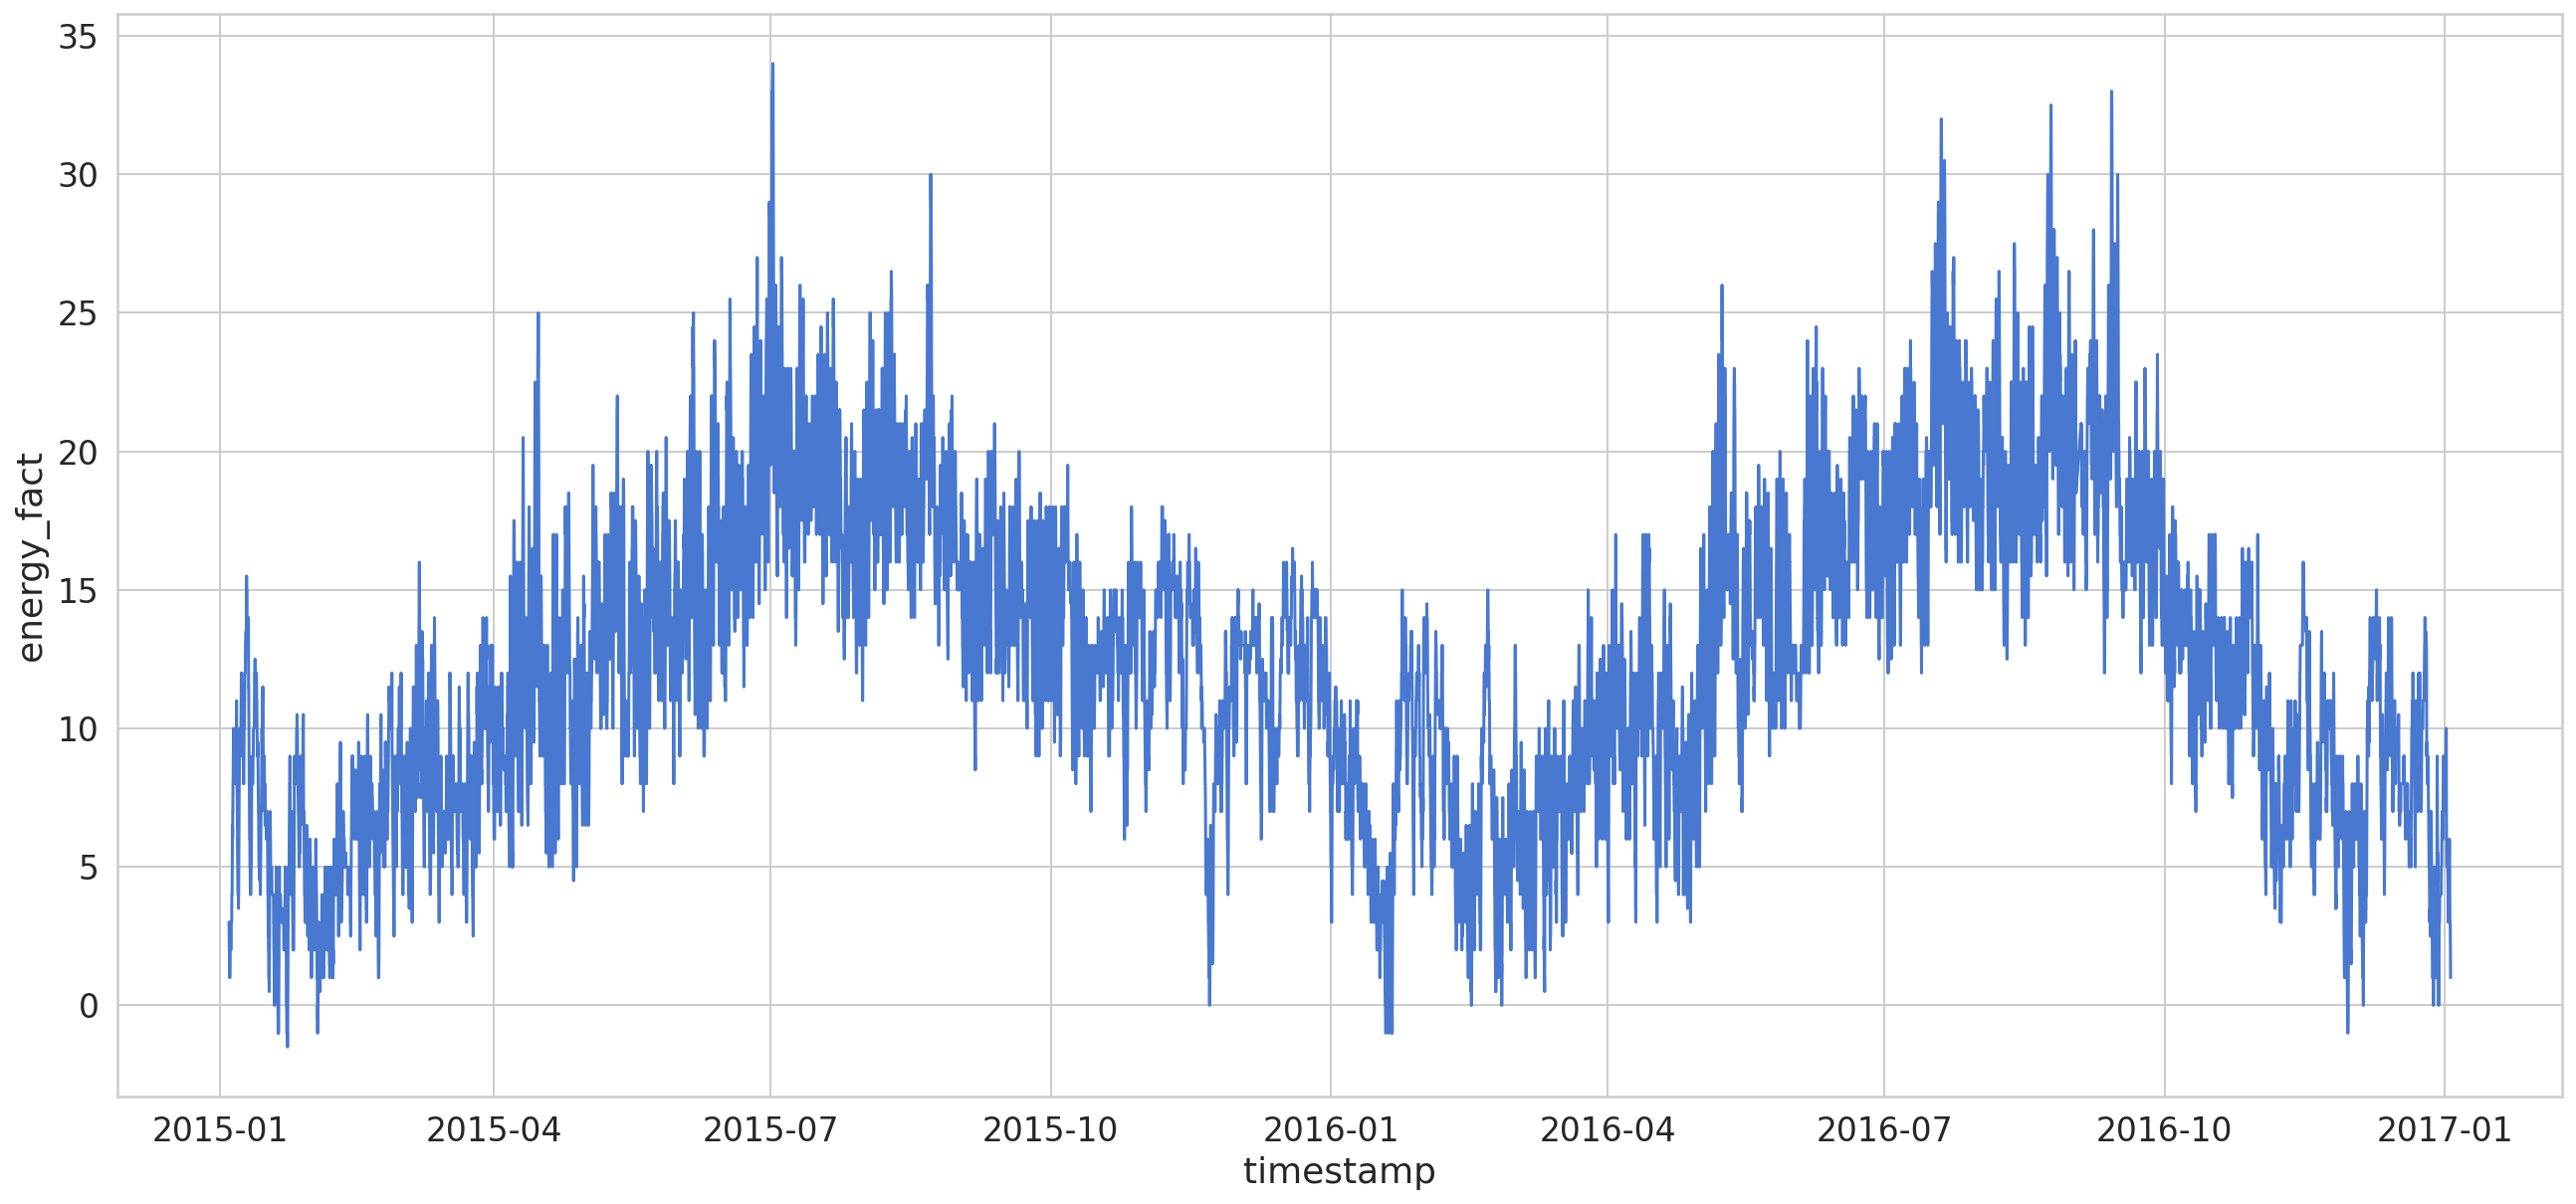

In [16]:
sns.lineplot(x=df.index, y="energy_fact", data=df);

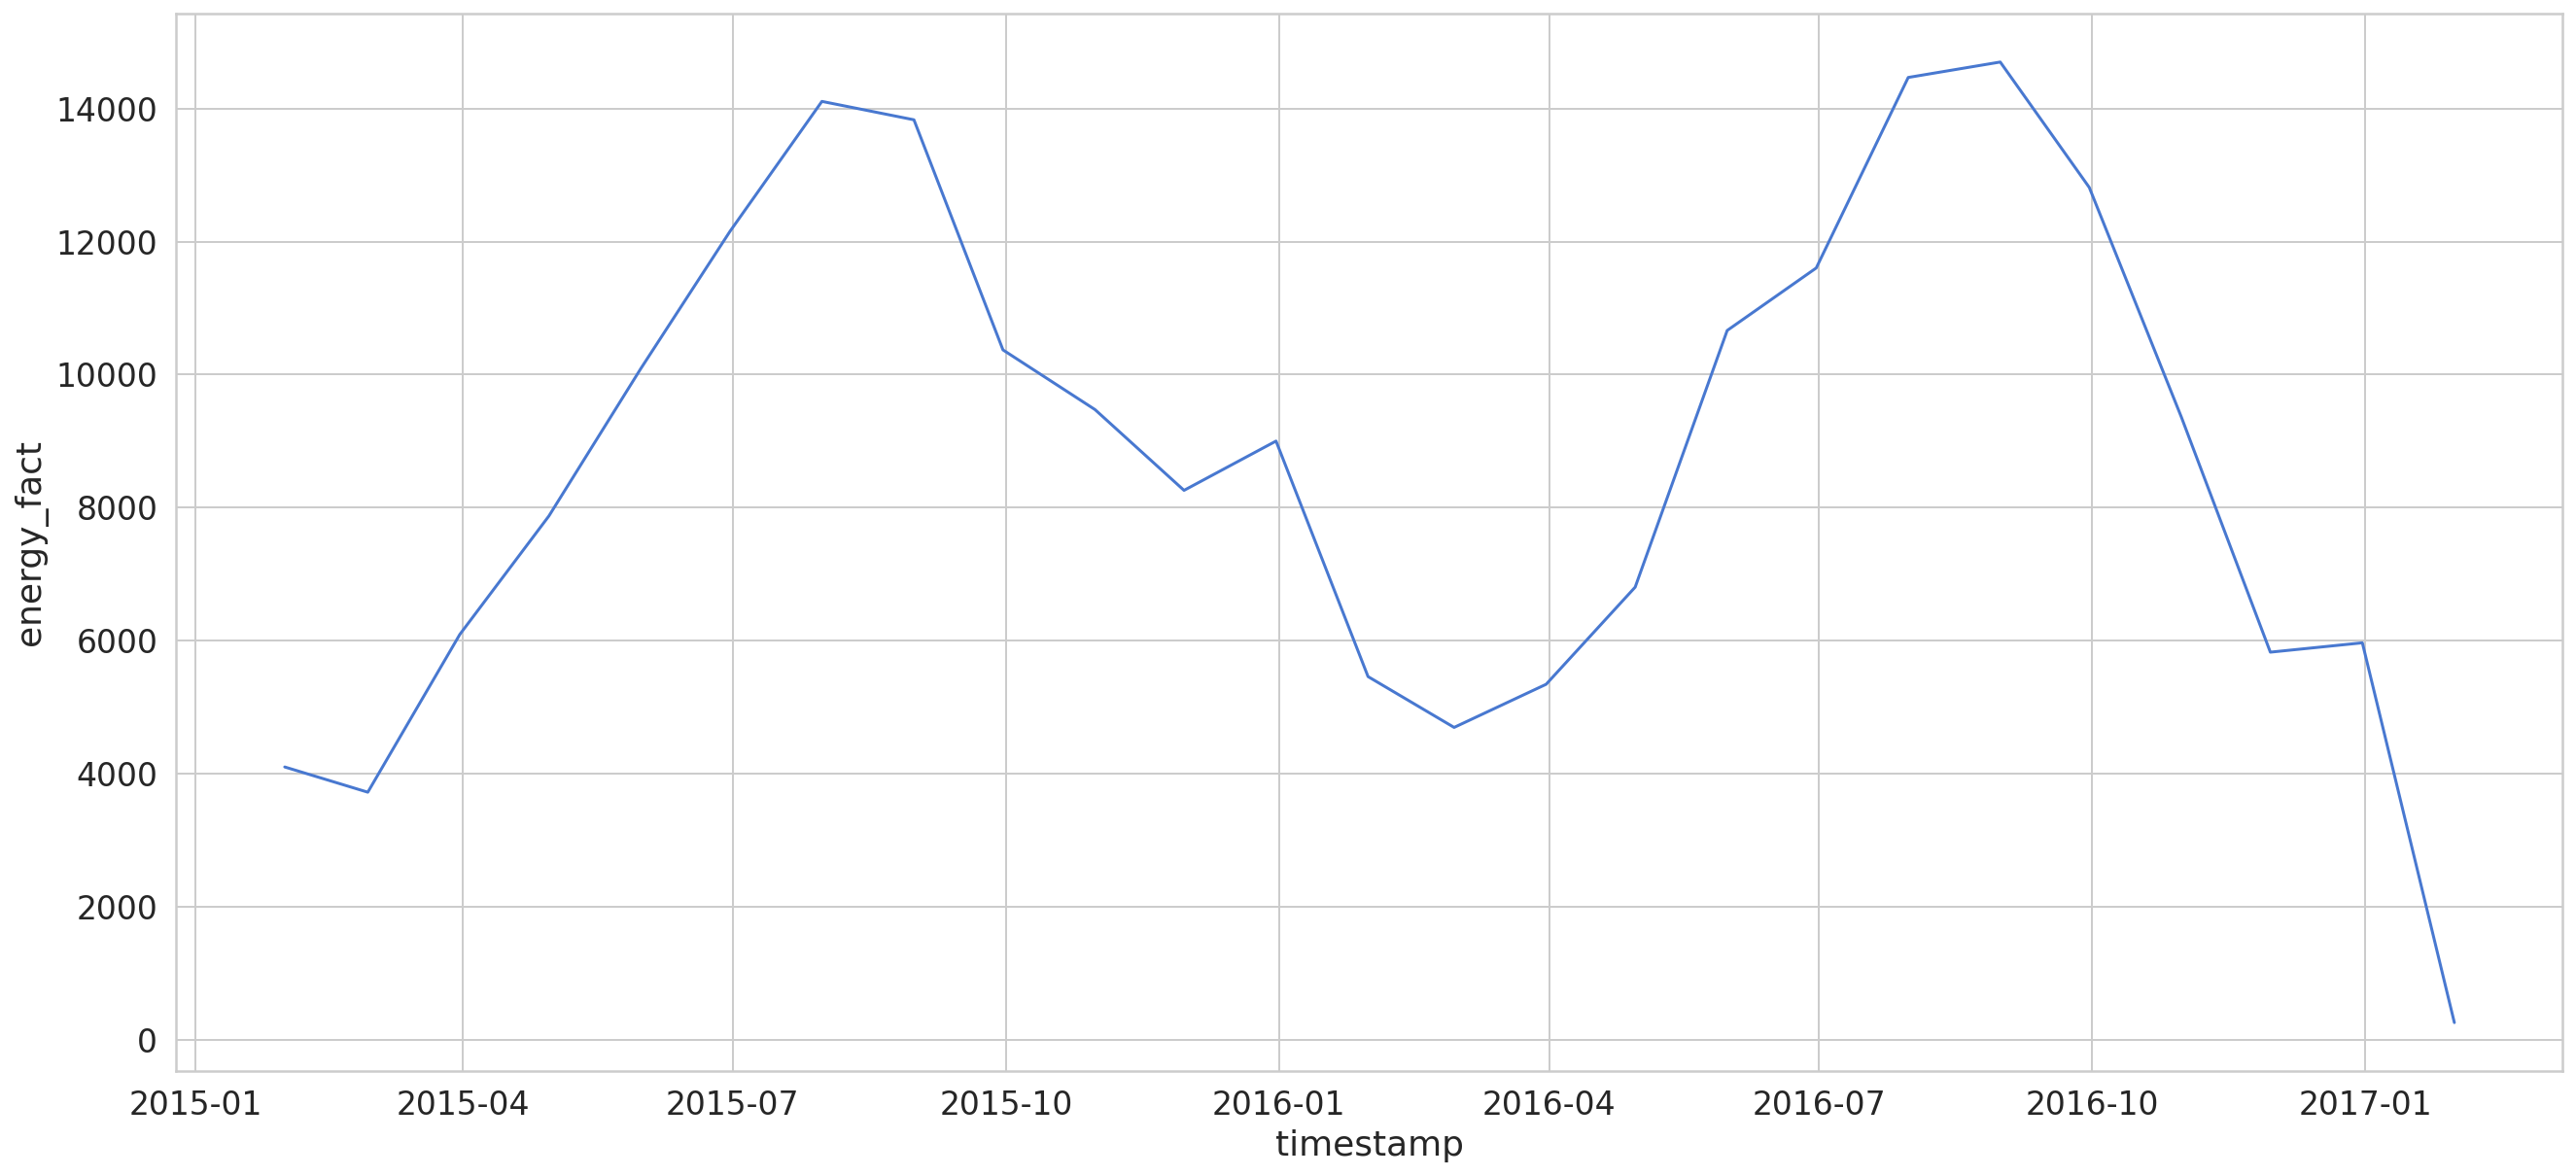

In [18]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="energy_fact", data=df_by_month);

In [19]:
df_by_month

,energy_fact,prod_plan,energy_plan_prev,energy_fact_prev,prod_plan_prev,prod_fact_prev,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,
2015-01-31,4101.000000,2255.500000,548710.0,4132.500000,2218.500000,50350.50,7709,11753,2014,671
2015-02-28,3721.500000,1868.000000,547930.0,3851.000000,2043.500000,51942.50,7707,9734,2015,1342
2015-03-31,6093.500000,4558.500000,703832.0,6077.000000,4523.000000,51668.25,8540,11751,2174,2217
2015-04-30,7873.000000,7112.500000,837622.0,7887.000000,7167.500000,48573.50,8270,11156,2131,2876
2015-05-31,10091.500000,9803.500000,893698.0,10164.000000,9904.500000,47905.00,8556,11904,2376,3720
2015-06-30,12151.500000,12073.000000,1048029.0,12518.000000,12457.000000,44087.00,8268,11145,2028,4302
2015-07-31,14107.000000,14060.000000,1121063.0,13874.000000,13823.000000,46745.50,8508,11831,2232,5180
2015-08-31,13830.500000,13816.500000,1016490.0,13778.000000,13766.500000,52493.00,8556,11904,2280,5952
2015-09-30,10371.000000,10357.500000,901484.0,10341.500000,10328.000000,51811.00,8210,11047,2045,6399


In [20]:
df_by_month.columns.to_list()

['energy_fact',
 'prod_plan',
 'energy_plan_prev',
 'energy_fact_prev',
 'prod_plan_prev',
 'prod_fact_prev',
 'hour',
 'day_of_month',
 'day_of_week',
 'month']

In [22]:
df.columns

Index(['energy_fact', 'prod_plan', 'energy_plan_prev', 'energy_fact_prev',
       'prod_plan_prev', 'prod_fact_prev', 'hour', 'day_of_month',
       'day_of_week', 'month'],
      dtype='object')

In [23]:
# Здесь будет долго - нужно сред деалть df.loc[df.index >= d0]
# fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
# fig.set_size_inches(18, 28)

# sns.pointplot(data=df, x=df.index, y='energy_fact', ax=ax1)
# sns.pointplot(data=df, x=df.index, y='energy_fact', hue='is_holiday', ax=ax2)
# sns.pointplot(data=df, x=df.index, y='energy_fact', hue='is_weekend', ax=ax3)
# sns.pointplot(data=df, x=df.index, y='energy_fact', hue='season', ax=ax4);

<AxesSubplot:xlabel='day_of_week', ylabel='energy_fact'>

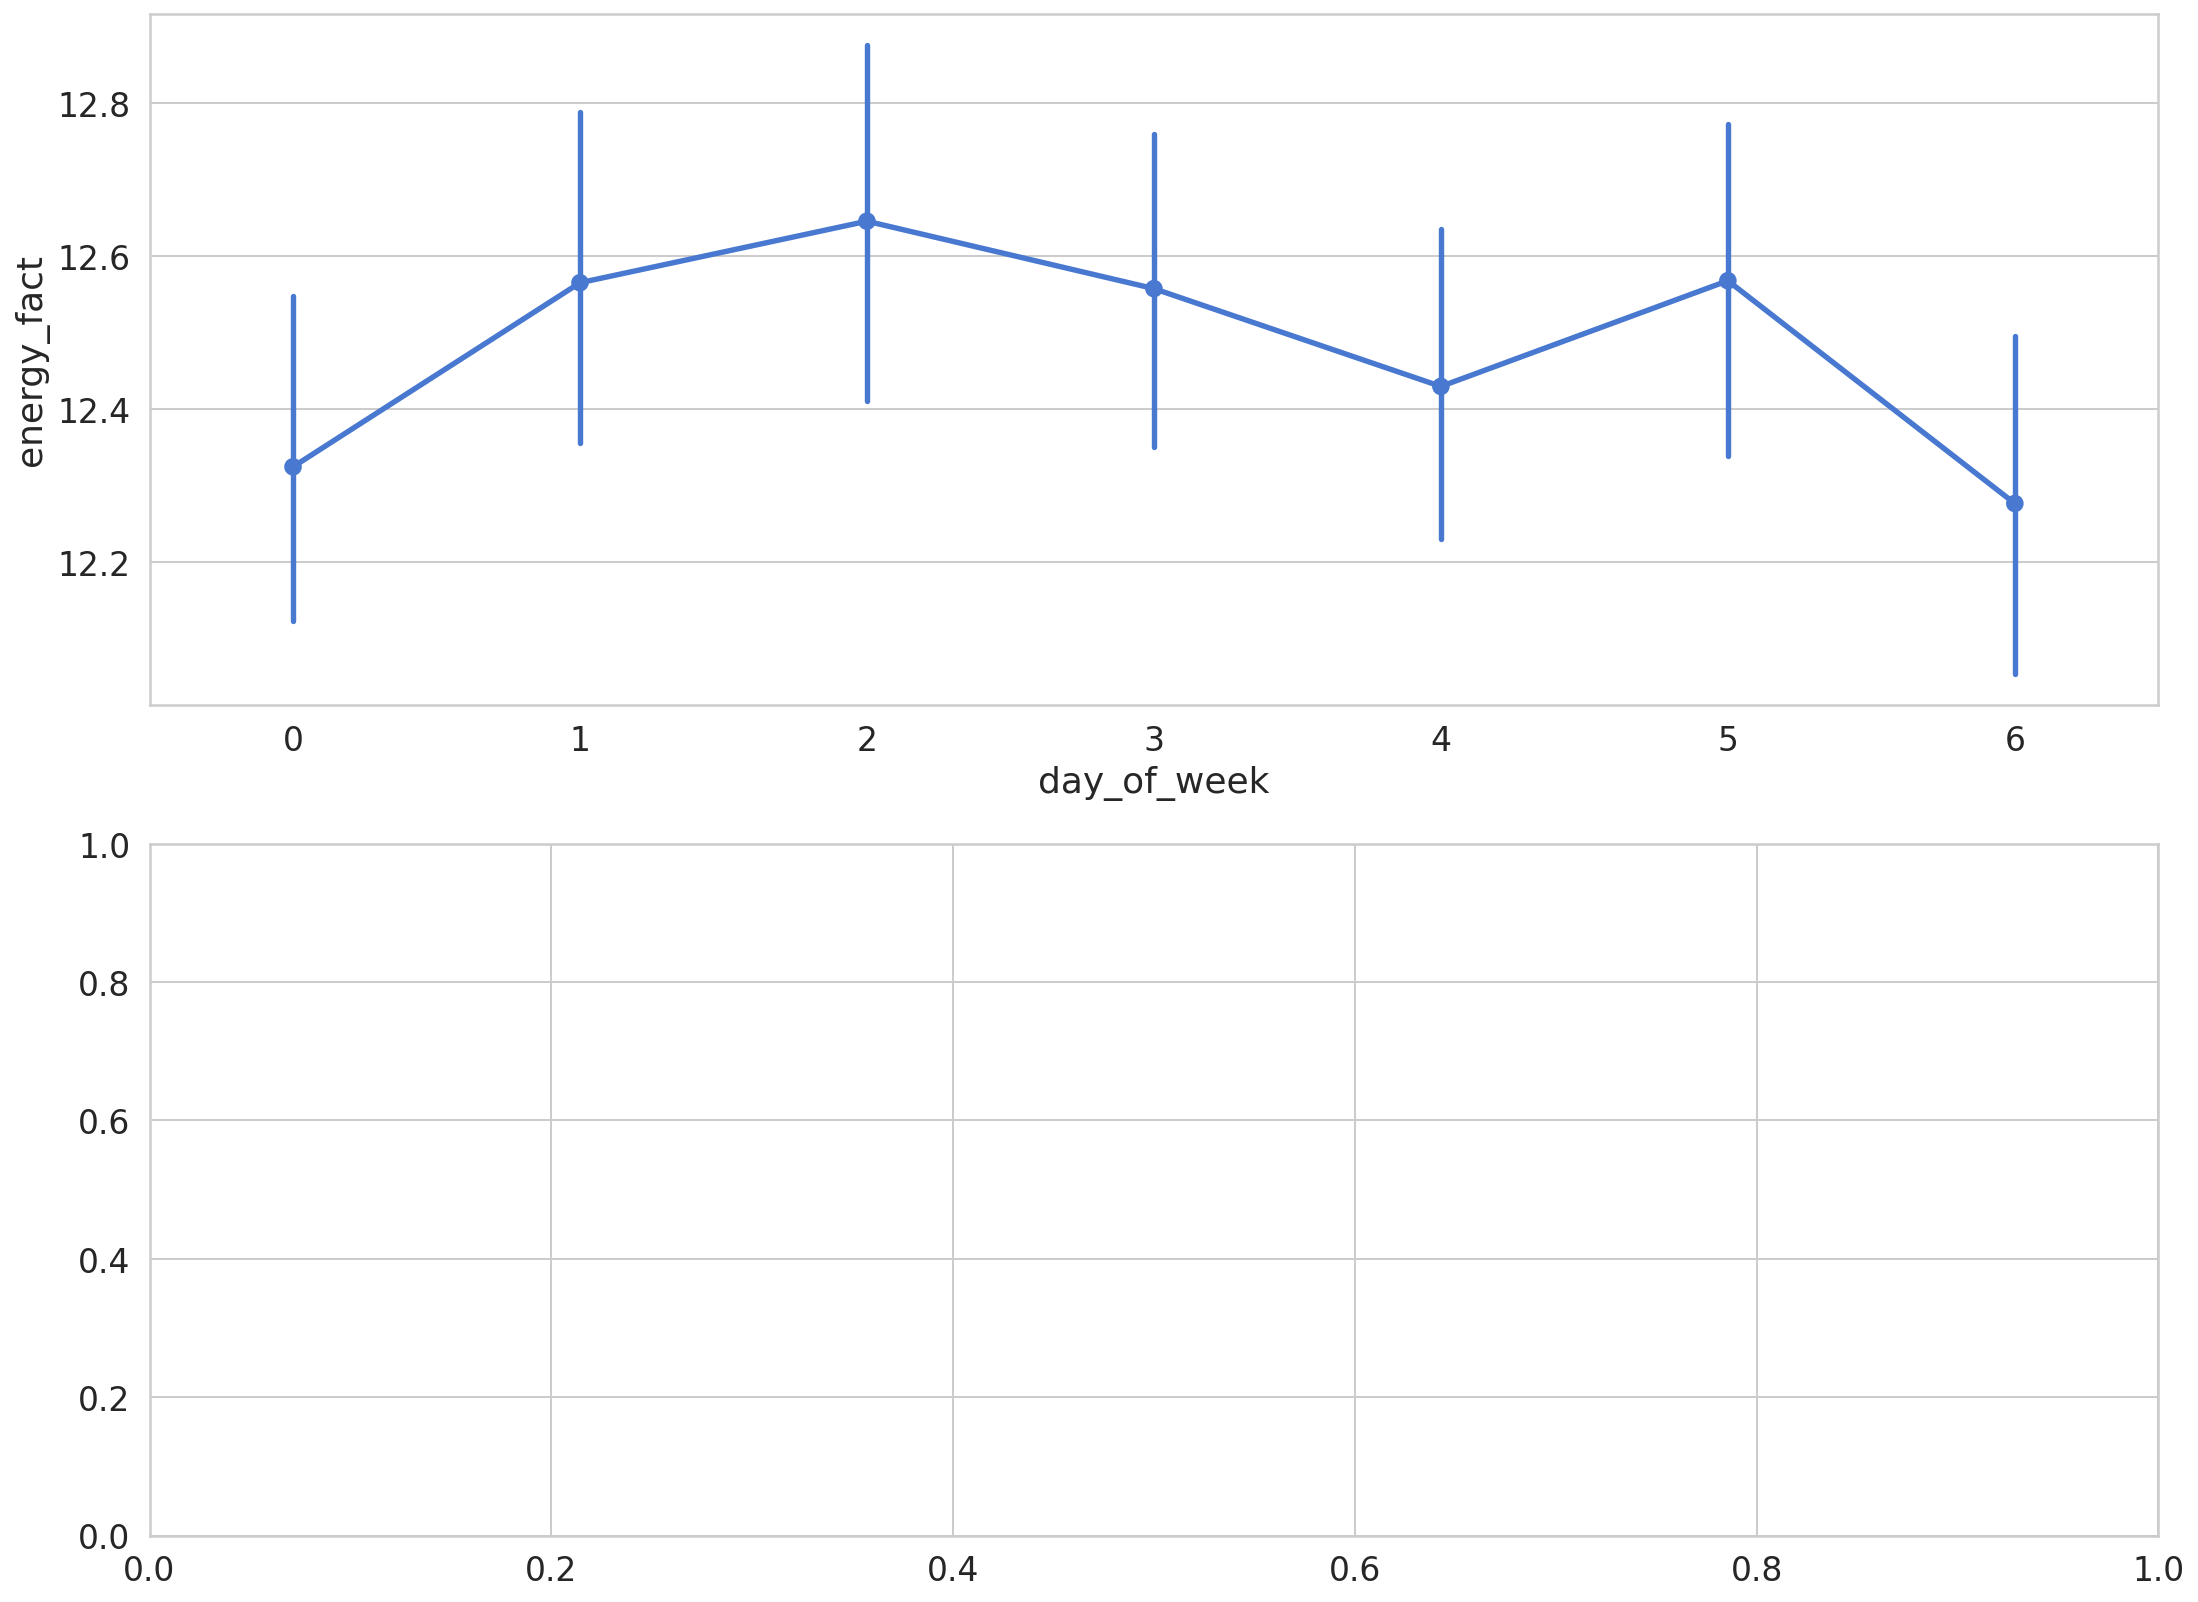

In [24]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='energy_fact', ax=ax1)
# sns.pointplot(data=df, x='day_of_week', y='energy_fact', hue='season', ax=ax2);

In [25]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15651 1739


# Preprocessing

In [26]:
from sklearn.preprocessing import RobustScaler

f_columns = ['energy_fact', 'prod_plan', 'energy_plan_prev', 'energy_fact_prev',
       'prod_plan_prev', 'prod_fact_prev']  # ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['energy_fact']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['energy_fact'] = cnt_transformer.transform(train[['energy_fact']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['energy_fact'] = cnt_transformer.transform(test[['energy_fact']])

In [28]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

In [29]:
time_steps = 24

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train['energy_fact'], time_steps)
X_test, y_test = create_dataset(test, test['energy_fact'], time_steps)

print(X_train.shape, y_train.shape)

(15627, 24, 10) (15627,)


In [30]:
model = keras.Sequential()

model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))


model.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
model

In [32]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
440/440 [==============================] - 15s 11ms/step - loss: 0.1467 - val_loss: 0.0093
Epoch 2/10
440/440 [==============================] - 3s 7ms/step - loss: 0.0239 - val_loss: 0.0034
Epoch 3/10
440/440 [==============================] - 3s 7ms/step - loss: 0.0185 - val_loss: 0.0315
Epoch 4/10
440/440 [==============================] - 3s 7ms/step - loss: 0.0112 - val_loss: 0.0046
Epoch 5/10
440/440 [==============================] - 4s 8ms/step - loss: 0.0106 - val_loss: 0.0084
Epoch 6/10
440/440 [==============================] - 3s 7ms/step - loss: 0.0088 - val_loss: 0.0034
Epoch 7/10
440/440 [==============================] - 3s 7ms/step - loss: 0.0067 - val_loss: 0.0013
Epoch 8/10
440/440 [==============================] - 3s 7ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 9/10
440/440 [==============================] - 4s 9ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 10/10
440/440 [==============================] - 3s 7ms/step - loss: 0.0059 - val_loss: 0.00

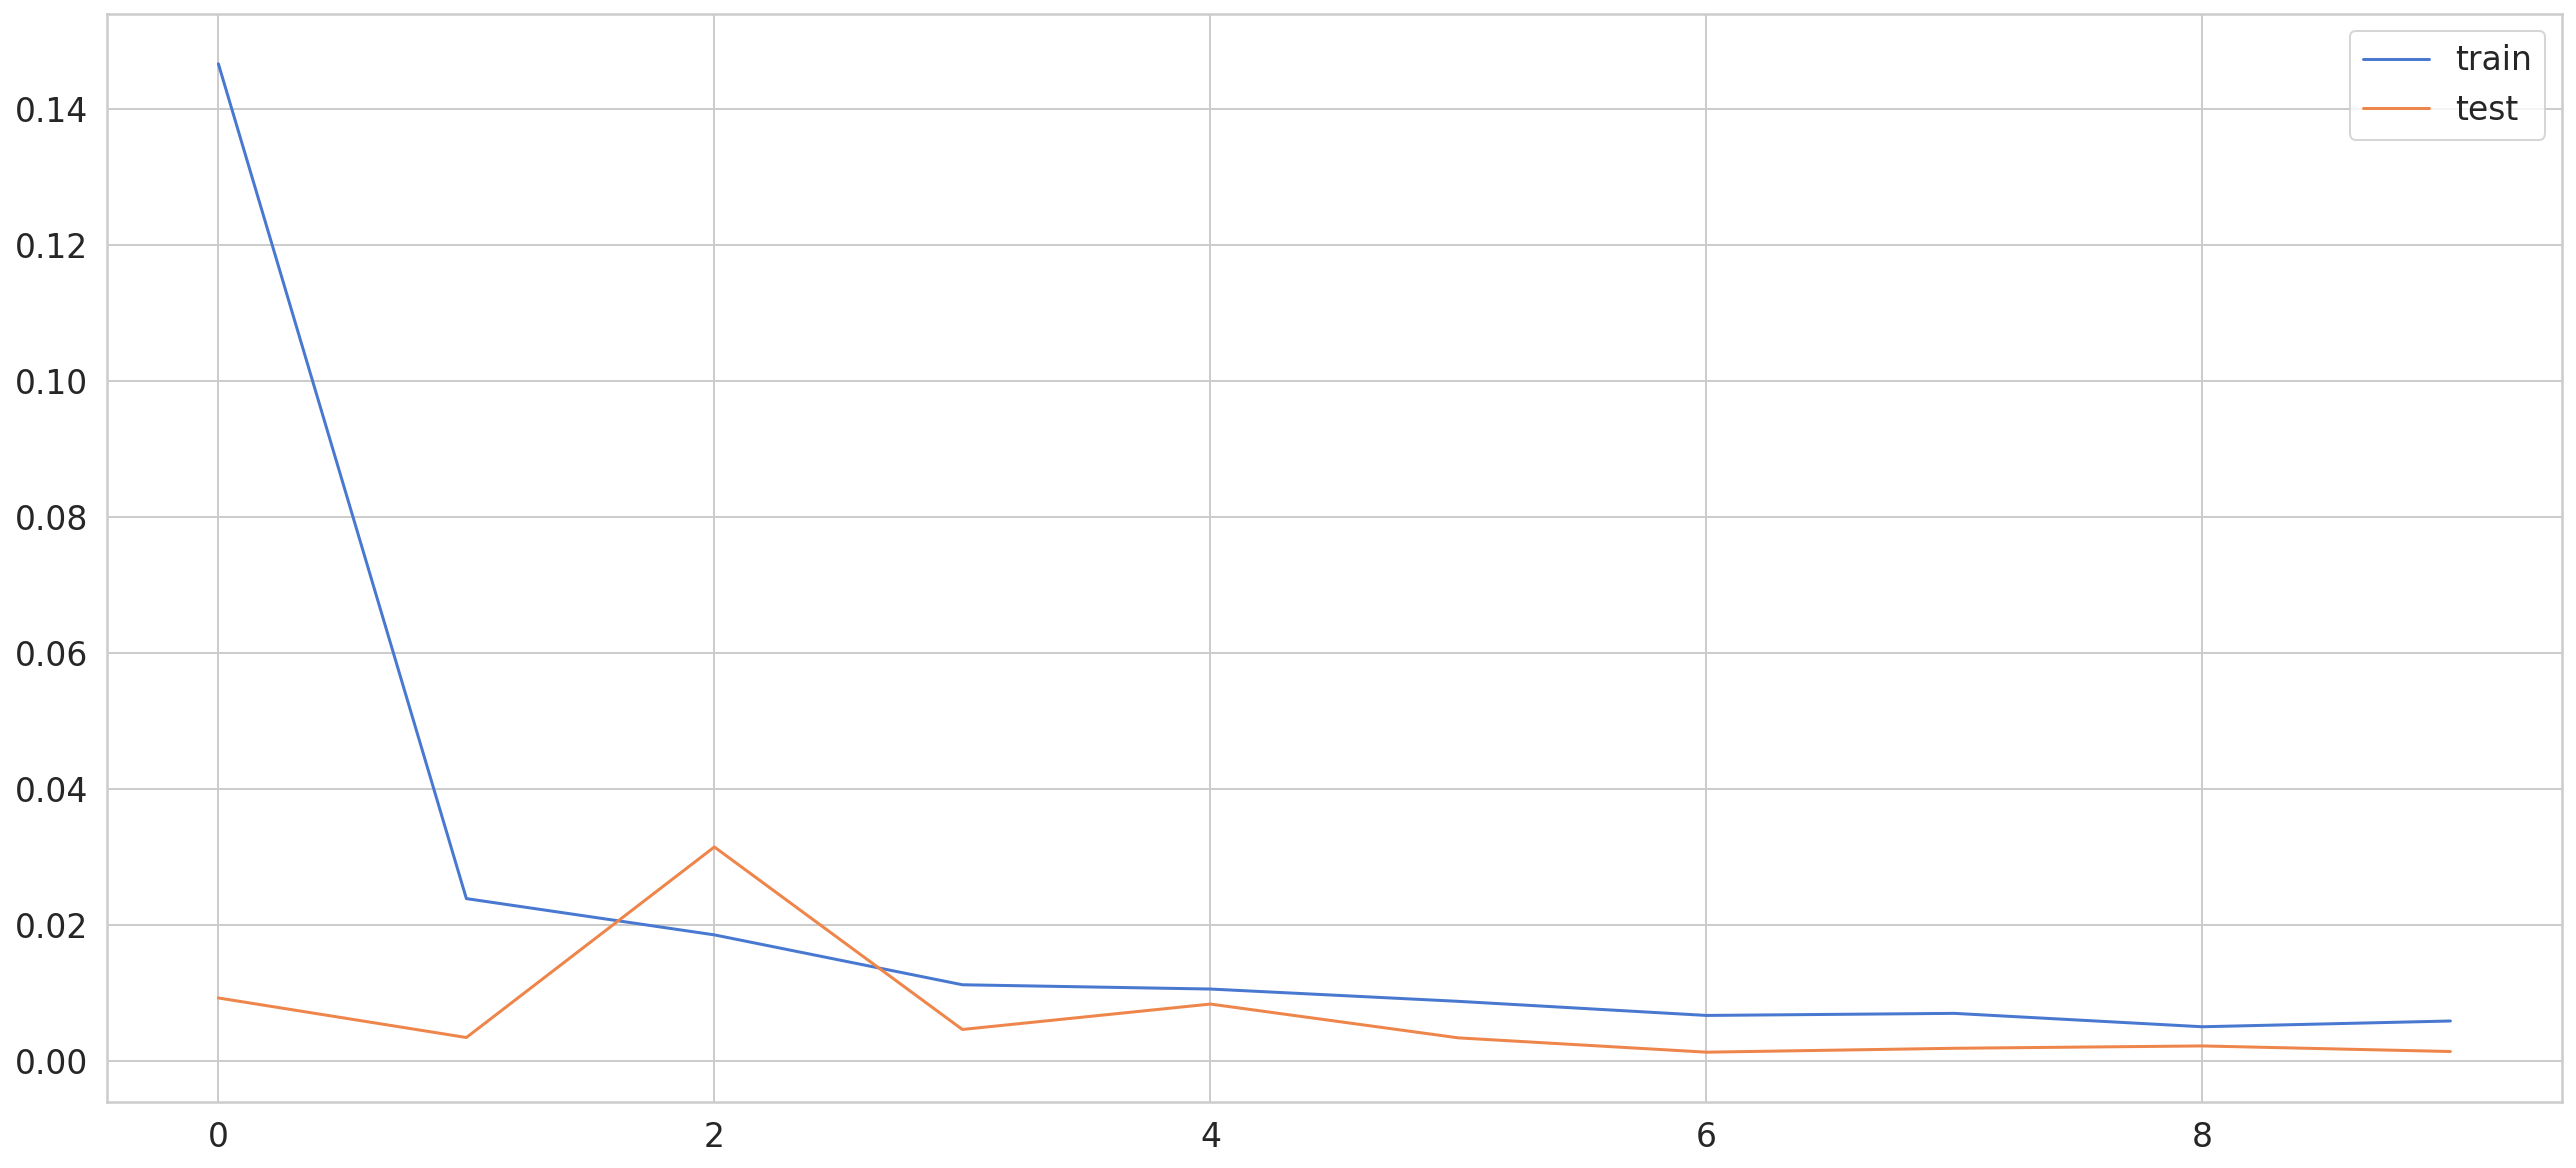

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [35]:
y_pred = model.predict(X_test)

54/54 [==============================] - 0s 3ms/step


In [36]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

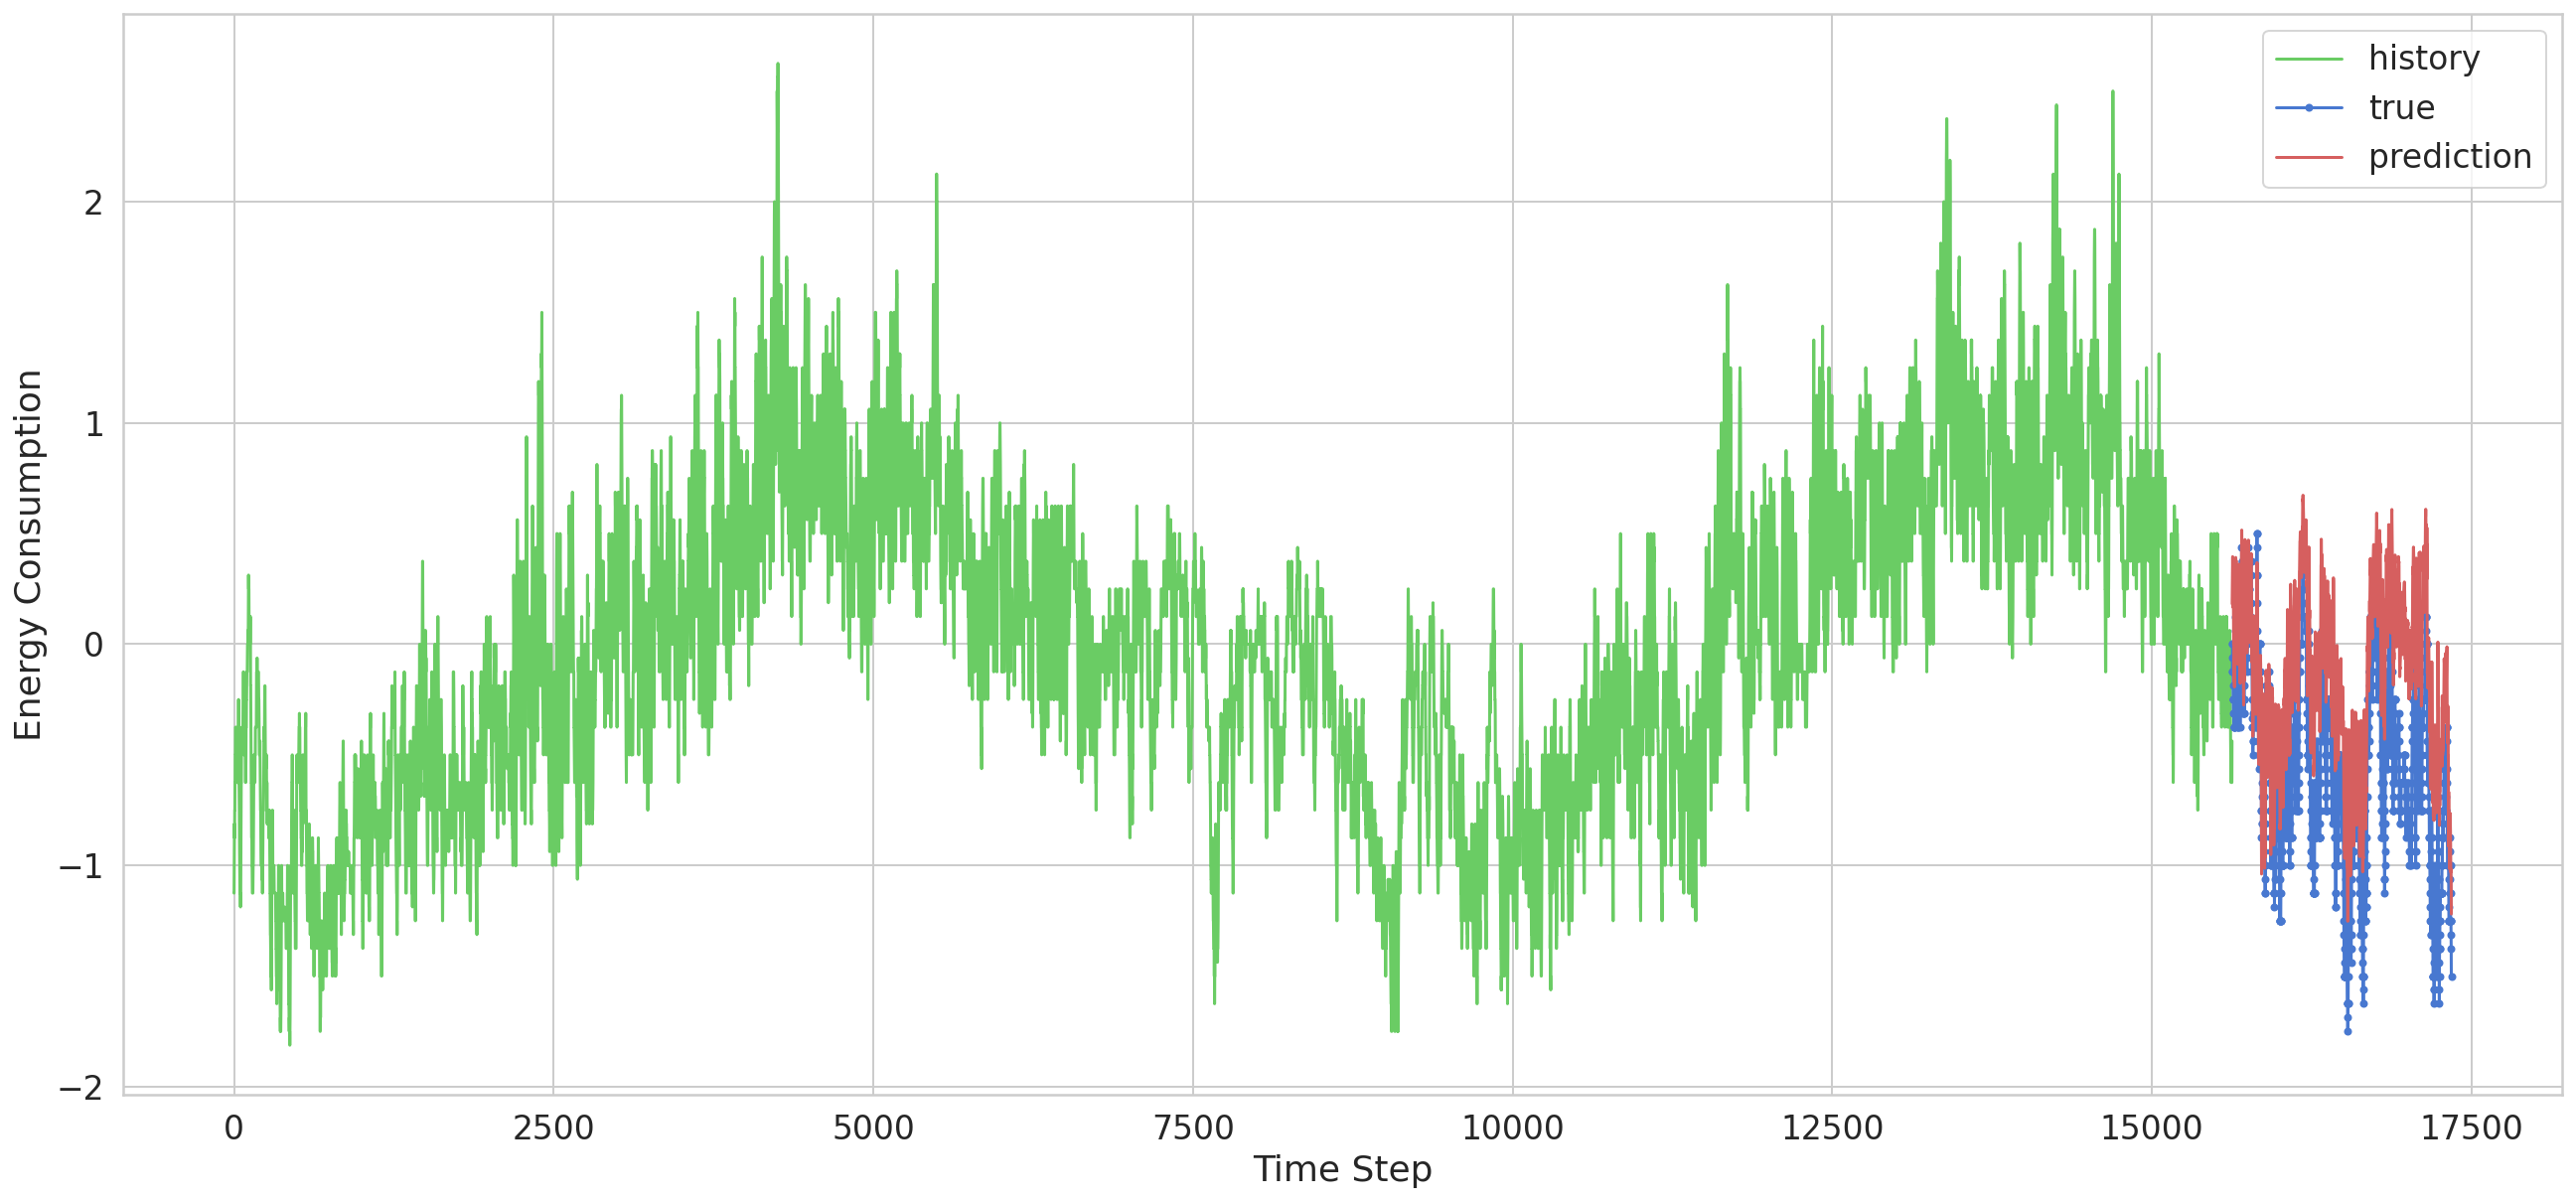

In [37]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Energy Consumption')
plt.xlabel('Time Step')
plt.legend()
plt.show();

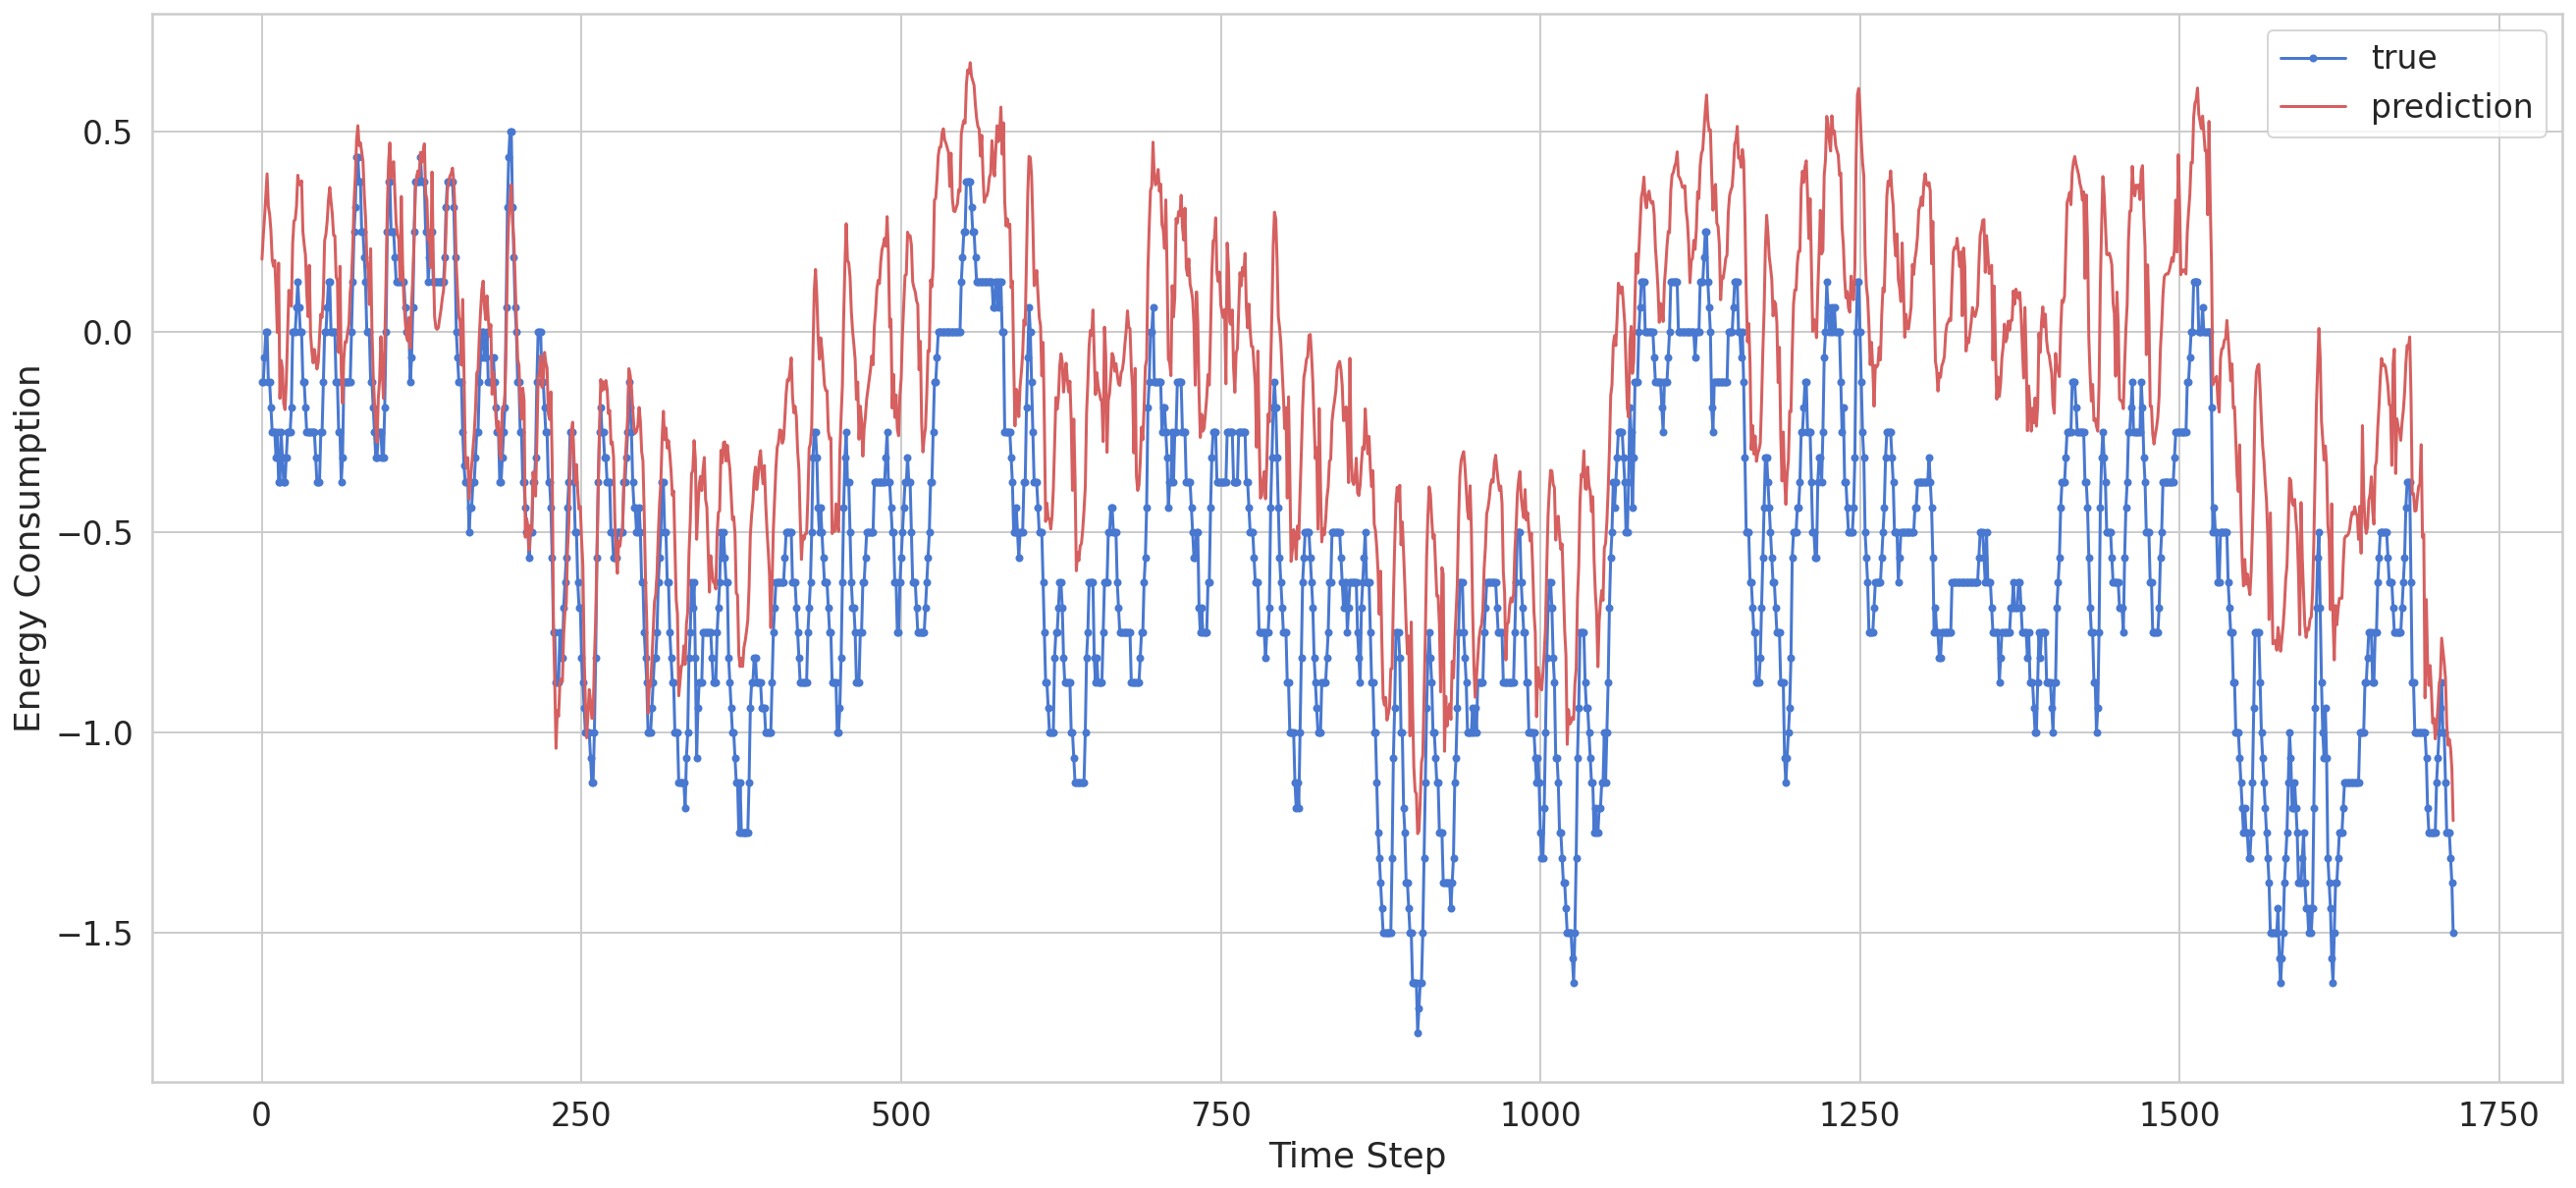

In [38]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Energy Consumption')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
# План:
# 1) посчитать целевую метрику качества на тесте, научиться сравнивать модели между собой
# 2) провести "timeseries tensorflow feature importance (FI)", для этого используй SHAP
# 3) Добавить ещё признаков, посмотреть и их FI
# 4) Поиграться с параметрами, возможно использовать байесовскую оптимизацию для твоей LSTM
# 5) Добавить моделей, сравнить их качество между собой, построить сводную таблицу
# 6) Попробовать stacking моделей между собой
# 7) Попробовать в метапризнаковое обучение модели
# 8) Сделать выводы и реализовать сервис для продакшена;)